
## Section B: Rebuild the tree using distance matrix

- Use Neighbor Joining Tree technique to build a graph based on the given distance matrix from ``result_code_part1.ipynb``.

- Neighbor Joining technique is explained in https://www.tenderisthebyte.com/blog/2022/08/31/neighbor-joining-trees/, and our code builds this technique from scratch for use.

- More concepts on how to build a tree graph based on a distance matrix is provided in https://www.kuniga.me/blog/2019/05/10/constructing-trees-from-a-distance-matrix.html

- Convention Used to name the variables:  
    * "D" is used to determine which two children nodes to drop
    
    * "d" is the pairwise distance used to build the distance matrix



In [3]:
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
import networkx as nx

In [4]:
# Below are functions we used 


def convert_D_to_dict(D_matrix, init_K_leaf):
    # convert distance matrix into node-to-node dictionary form {(node A, node B): distance,...}
    # (a,b) and (b,a) are distinctly counted
    d = {}
    for i in init_K_leaf:
        for j in init_K_leaf: 
            d[(i,j)] = D_matrix[i][j]
    
    return d
    


def net_divergence(d, K_leaf):
    # Net divergence r for a node i with the rest of all active nodes in K_leaf
    # D is the latest distance matrix in dict form
    # K_leaf : the set of active leaf nodes
    
    # output: dict contains node name and its corresponding net divergence value.
    
    L = float(len(K_leaf)) 
    # pairs = list(itertools.combinations(K_leaf, 2))
    r = {}
    for i in K_leaf:
        # compute i's net divergence w.r.t. all other nodes, (a,b) and (b,a) are distinctly counted
        r[i]=0
        for j in K_leaf:
            if j != i:
                r[i] += d[(i,j)]
        r[i] = (1/(L-2)) * r[i]
    return r
        
    


def adjusted_distance(D, K_leaf, r):
    # This function is to identify which two nodes are about to be linked towards a parent node
    # output: a dict
    pairs = list(itertools.combinations(K_leaf, 2)) # get all possible 2 nodes pairs from the active leaf list, method refers to: https://stackoverflow.com/questions/20762574/combinations-with-two-elements
    D_adjusted = {}
    for p in pairs:
        D_adjusted[p] = D[p] - (r[p[0]] + r[p[1]])
    
    return D_adjusted





def distance_from_child_to_parent(p:(), D:{}, r:{}, K_leaf:[], d_old:{}, d_new:{}):
    '''
    1. build 2 new edges from two identified child nodes (picked_pair p) linking to a same parent node, 
        assign this parent with a new label 
    2. remove the two children nodes identified in (picked_pair p) from the d_old & K_leaf, so that they won't appear in the next iteration's d_old
    
  
    param:
    inputs:
        - p: Selected 2 children nodes (nodeA, nodeB). 
        - D: Adjusted distance matrix computed from the previous iteration
        - r: Net divergence computed from the previous iteration
        - K_leaf: Active leaf nodes from the previous iteration
        - d_old: Pairswise distance of nodes that are not uet been groupped from the last iteration
        - d_new Pairwise distance of nodes that are already groupped from the last iteration. Will use this to plot the tree at the end of the iteration.
    output:
        - d_all
    
    
    '''
    new_parent_lb = max(K_leaf)+1 # assign a lb to the new parent node
    K_leaf.append(new_parent_lb)
    K_leaf.remove(p[0])
    K_leaf.remove(p[1])
    
    # update the distance matrix by removing the picked pair (2 leaf nodes) 
    # and adding one parent node (treated as a new leaf node, although it is the intermediate node when we look at the whole tree graph)

    '''
    - Compute distance from child (removed pairs) to parent (newly created intermediate node)
    - For removed pair <i,j> --> use d(ik) = [d(ij) + r(i) - r(j)] / 2    &   d(jk) = [d(ij) + r(j) - r(i)] / 2
    '''    
    d_new[(p[0], new_parent_lb)] = (D[(p[0],p[1])] + r[p[0]] - r[p[1]])/2
    d_new[(p[1], new_parent_lb)] = (D[(p[0],p[1])] + r[p[1]] - r[p[0]])/2
    
    
    '''
    - Compute the rest of leaf (non-child) to new node (aka, the parent of node removed pair <i,j>)
    - Use d(mk) = [d(im) + d(jm) - d(ij)] / 2
    '''
    # K_leaf is now contains newly added parent node with its labelled assigned with the largest number
    for i in K_leaf:
        # compute i's net divergence w.r.t. all other nodes, (a,b) and (b,a) are distinctly counted
        if i != new_parent_lb:
            d_old[(new_parent_lb, i)] = (d_old[(p[0], i)] + d_old[(p[1], i)] - d_old[p])/2
            d_old[(i, new_parent_lb)] = d_old[(new_parent_lb, i)]
    
    # Remove edges in d_all that link to the picked_pair children nodes, since the next iteration only based on 
    # the newly created parent & the rests of nodes
    for key in list(d_old.keys()):
        if key[0] in p or key[1] in p:
            del d_old[key]
            
    return d_old, d_new, K_leaf






def plot_tree(d_all, root_id):
    # refer: https://networkx.org/documentation/stable/auto_examples/drawing/plot_weighted_graph.html#sphx-glr-auto-examples-drawing-plot-weighted-graph-py
    G = nx.Graph()
    
    for key in d_all:
        G.add_edge(key[0], key[1], weight=d_all[key])
        
    e = [(u, v) for (u, v, d) in G.edges(data=True)]

    pos = nx.planar_layout(G)  # positions for all nodes - seed for reproducibility

    # nodes
    nx.draw_networkx_nodes(G, pos, node_size=700)
    nx.draw_networkx_nodes(G, pos, nodelist=[root_id], node_color="tab:red")

    # edges
    nx.draw_networkx_edges(G, pos, edgelist=e, width=2)

    # node labels
    nx.draw_networkx_labels(G, pos, font_size=6, font_family="sans-serif")

    ax = plt.gca()
    ax.margins(0.08)
    plt.axis("off")
    plt.tight_layout()
    plt.show()

### Rebuild the tree topology of nodes using the distance matrix $D_r$. 

- The root node is marked in red color in the generated figure.

Initial K_leaf: [0, 1, 2, 3, 4, 5, 6, 7, 8]
Iteration 1
- K_leaf is [0, 1, 3, 4, 5, 6, 7, 9]
Iteration 2
- K_leaf is [0, 1, 3, 4, 6, 7, 10]
Iteration 3
- K_leaf is [0, 1, 4, 7, 10, 11]
Iteration 4
- K_leaf is [0, 1, 10, 11, 12]
Iteration 5
- K_leaf is [1, 10, 12, 13]
Iteration 6
- K_leaf is [10, 13, 14]
Iteration 7
- K_leaf is [14, 15]


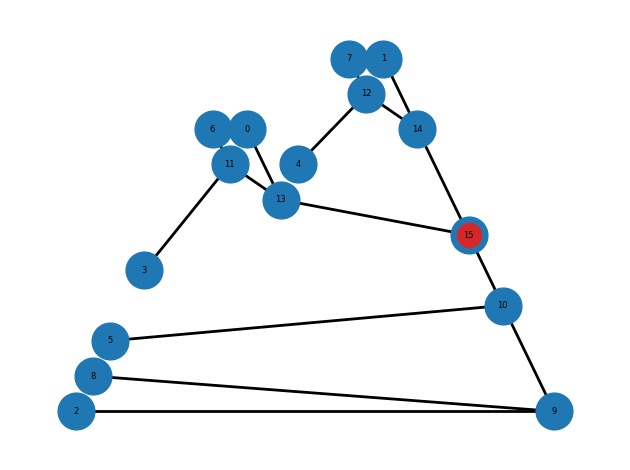

In [5]:
with open('output sample/D_r.npy','rb') as f:
        D_r_matrix = np.load(f)
        
with open('output sample/D_x.npy','rb') as f:
    D_x_matrix = np.load(f)

K_leaf = [e for e in range(D_x_matrix.shape[0])]    
d_old = convert_D_to_dict(D_matrix=D_x_matrix, init_K_leaf=K_leaf)
d_new = {}


print(f"Initial K_leaf: {K_leaf}")


# Iteration starts
step = 0
while len(K_leaf)>2:
    
    step +=1
    print(f"Iteration {step}")
    r = net_divergence(d_old, K_leaf)
    D_adjusted = adjusted_distance(d_old, K_leaf, r)
    
    
    pair_min = min(D_adjusted, key=D_adjusted.get) # this line picks who are the 2 children nodes to be dropped
    d_old, d_new, K_leaf = distance_from_child_to_parent(p=pair_min, D=D_adjusted, r=r, K_leaf=K_leaf, d_old=d_old, d_new=d_new)
    print(f"- K_leaf is {K_leaf}")


# when only 2 leaf nodes lefted in K_leaf, then we connect an edge between them using their distance
# apend this distance into the d_new dictionary:
d_new.update(d_old)
root_id = max(K_leaf) # the root node ID is the biggest lb number in K_leaf, we use it to color-code the node of tree graph 


plot_tree(d_new, root_id)